### Etymology Prefix Suffix Analysis

In [1]:
import os
import pandas as pd
import numpy as np
import glob
import re
from kneed import KneeLocator
from pathlib import Path
import shutil

In [2]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> native language

# pre-suffix select
prefix = True  # True, False  word is prefix  example: prefix = True and suffix = False for Turkish word
suffix = False # True, False  word is suffix

# native word select
word_analysis = True  # True, False  Not: True for native word analysis, False for etymological word analysis
file_ext = 5000
word_start = 1000  # 0  # native word start index
word_end = 5000  # 28  # native word end index


In [3]:
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)
Path(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}").mkdir(parents=True, exist_ok=True)

### Prefix Suffix Analysis

In [4]:
def detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False):
    '''
    default parameter:\n
    detect_prefix_suffix_word(df, df_column, word_ety_list, prefix_word=True, suffix_word=False)\n
    detect_prefix_suffix_word(df, "word", ["abacus","aba","su"], prefix=True, suffix=True)\n
    df is dataframe. Each word of word_ety_list search in df_column according to prefix_word and suffix_word condition.\n
    prefix_word and suffix_word are not extention. they represents location of word of word_ety_list (word before or after)
    '''    
    df_ety_prefix_suffix_word_result = pd.DataFrame()
    for i in word_ety_list:
        # suffix result
        if suffix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"{i}(?:$)", na=True)]  # string+ext=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass
        # prefix result
        if prefix_word:
            word_ety_in_word = df[df[f"{df_column}"].str.contains(fr"(?:^){i}", na=True)]  # ext+string=> word
            word_ety_in_word.insert(0,"search_word",i)
            df_ety_prefix_suffix_word_result = pd.concat([df_ety_prefix_suffix_word_result,word_ety_in_word], axis=0)
        else:
            pass    
        
    #df_ety_suffix_word_result = df_word_result.sort_values(by="frequency", ascending=False)
    df_ety_prefix_suffix_word_result.drop_duplicates(inplace=True)
    df_ety_prefix_suffix_word_result.reset_index(drop=True, inplace=True)

    return df_ety_prefix_suffix_word_result 

In [5]:
def exract_prefix_suffix(df, source_column, target_column):
    '''
    exract_prefix_suffix(df, source_column, target_column):\n
    exract_prefix_suffix(df, "word_pair", "word"):\n
    df is dataframe. word of source_column search in target_column\n
    and exract prefix or suffix. 
    '''
    for i in range(len(df)):
        source_word = df.loc[i,f"{source_column}"]
        target_word = df.loc[i,f"{target_column}"]
        try:
            search_loc = re.search(fr"{source_word}", target_word, re.UNICODE|re.IGNORECASE)
            search_loc_start = search_loc.span()[0]
            search_loc_end = search_loc.span()[1]
            if search_loc_start > 0:
                var1= target_word[0:search_loc_start]
                prefix_suffix = f"{var1}+"
                df.loc[i,"prefix_suffix"] = prefix_suffix                
            else:
                var2 = target_word[search_loc_end:]
                prefix_suffix = f"+{var2}" 
                df.loc[i,"prefix_suffix"] = prefix_suffix 
        except:
            pass
    return df

##### Prefix Suffix All

In [6]:
df_word_all = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
df_word_all

,word,frequency
0,bir,18835735
1,bu,11062659
2,ne,8025880
3,ve,7766036
4,için,5484109
...,...,...
988212,karneleme,5
988213,karnaya,5
988214,dörtlümüzün,5
988215,karnavalınız,5


In [7]:
if word_analysis:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/{lang_folder.lower().capitalize()}/Deployment/Data/Word/Word_Merge_Preprocess.xlsx")
    #df_pair = df_pair.head(word_num)
    df_pair = df_pair.iloc[word_start:word_end,]
    df_pair.rename(columns={"word":"dict_entry_main"}, inplace=True)
else:
    df_pair = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Vocabulary.xlsx")
df_pair

,dict_entry_main,frequency
200,onunla,399330
201,yapıyorsun,398274
202,neler,397377
203,ister,396177
204,emin,395177
...,...,...
995,istiyorsunuz,71208
996,herşeyi,71175
997,görev,71055
998,getirdim,70790


In [8]:
word_ety_list = df_pair["dict_entry_main"].values.tolist()
#word_ety_list

In [9]:
df_prefix_suffix_word = detect_prefix_suffix_word(df_word_all, "word", word_ety_list, prefix_word=prefix, suffix_word=suffix)
df_prefix_suffix_word

,search_word,word,frequency
0,onunla,onunla,399330
1,onunla,onunlayken,1143
2,onunla,onunlayım,865
3,onunla,onunlaydım,776
4,onunla,onunlaydı,413
...,...,...,...
446523,dinleyin,dinleyinben,6
446524,dinleyin,dinleyinçocuklar,6
446525,dinleyin,dinleyinn,5
446526,dinleyin,dinleyinguru,5


In [10]:
df_prefix_suffix = exract_prefix_suffix(df_prefix_suffix_word, "search_word", "word")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,onunla,onunla,399330,+
1,onunla,onunlayken,1143,+yken
2,onunla,onunlayım,865,+yım
3,onunla,onunlaydım,776,+ydım
4,onunla,onunlaydı,413,+ydı
...,...,...,...,...
446523,dinleyin,dinleyinben,6,+ben
446524,dinleyin,dinleyinçocuklar,6,+çocuklar
446525,dinleyin,dinleyinn,5,+n
446526,dinleyin,dinleyinguru,5,+guru


In [11]:
df_prefix_suffix.search_word.nunique()

800

In [12]:
df_prefix_suffix.word.nunique()

356900

In [13]:
if word_analysis:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_All.xlsx", index=False)
else:
    df_prefix_suffix.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx", index=False)

##### Select From Length

In [14]:
if word_analysis:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_All.xlsx")
else:
    df_prefix_suffix = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_All.xlsx")
df_prefix_suffix

,search_word,word,frequency,prefix_suffix
0,onunla,onunla,399330,+
1,onunla,onunlayken,1143,+yken
2,onunla,onunlayım,865,+yım
3,onunla,onunlaydım,776,+ydım
4,onunla,onunlaydı,413,+ydı
...,...,...,...,...
446523,dinleyin,dinleyinben,6,+ben
446524,dinleyin,dinleyinçocuklar,6,+çocuklar
446525,dinleyin,dinleyinn,5,+n
446526,dinleyin,dinleyinguru,5,+guru


In [15]:
df_prefix_suffix["prefix_suffix_len"] = df_prefix_suffix["prefix_suffix"].apply(lambda x: (len(x)-1))
df_prefix_suffix

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,onunla,onunla,399330,+,0
1,onunla,onunlayken,1143,+yken,4
2,onunla,onunlayım,865,+yım,3
3,onunla,onunlaydım,776,+ydım,4
4,onunla,onunlaydı,413,+ydı,3
...,...,...,...,...,...
446523,dinleyin,dinleyinben,6,+ben,3
446524,dinleyin,dinleyinçocuklar,6,+çocuklar,8
446525,dinleyin,dinleyinn,5,+n,1
446526,dinleyin,dinleyinguru,5,+guru,4


In [16]:
prefix_suffix_mean = int(round(df_prefix_suffix["prefix_suffix_len"].mean(),0))
prefix_suffix_mean

8

In [17]:
df_prefix_suffix_select = df_prefix_suffix[df_prefix_suffix["prefix_suffix"].str.len() <= prefix_suffix_mean]
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,onunla,onunla,399330,+,0
1,onunla,onunlayken,1143,+yken,4
2,onunla,onunlayım,865,+yım,3
3,onunla,onunlaydım,776,+ydım,4
4,onunla,onunlaydı,413,+ydı,3
...,...,...,...,...,...
446522,dinleyin,dinleyindiyor,7,+diyor,5
446523,dinleyin,dinleyinben,6,+ben,3
446525,dinleyin,dinleyinn,5,+n,1
446526,dinleyin,dinleyinguru,5,+guru,4


In [18]:
if word_analysis:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_Select.xlsx", index=False)
else:
    df_prefix_suffix_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx", index=False)

##### Select With Prefix Suffix

In [19]:
if word_analysis:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_Select.xlsx")
else:
    df_prefix_suffix_select = pd.read_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Select.xlsx")
df_prefix_suffix_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,onunla,onunla,399330,+,0
1,onunla,onunlayken,1143,+yken,4
2,onunla,onunlayım,865,+yım,3
3,onunla,onunlaydım,776,+ydım,4
4,onunla,onunlaydı,413,+ydı,3
...,...,...,...,...,...
205305,dinleyin,dinleyindiyor,7,+diyor,5
205306,dinleyin,dinleyinben,6,+ben,3
205307,dinleyin,dinleyinn,5,+n,1
205308,dinleyin,dinleyinguru,5,+guru,4


In [20]:
df_prefix_suffix_freq = df_prefix_suffix_select[["prefix_suffix"]].value_counts().reset_index()
df_prefix_suffix_freq.rename(columns={0:"frequency"}, inplace=True)
df_prefix_suffix_freq

,prefix_suffix,frequency
0,+,800
1,+n,257
2,+da,242
3,+i,241
4,+lar,238
...,...,...
120732,+kimlara,1
120733,+kimken,1
120734,+kimizn,1
120735,+kimizle,1


In [21]:
prefix_suffix_freq_sum = df_prefix_suffix_freq.loc[:,"frequency"].sum()
prefix_suffix_freq_sum

205310

In [22]:
df_prefix_suffix_freq["ratio"] = round(((df_prefix_suffix_freq.loc[:,"frequency"]/prefix_suffix_freq_sum)*100),7)
df_prefix_suffix_freq


,prefix_suffix,frequency,ratio
0,+,800,0.389655
1,+n,257,0.125177
2,+da,242,0.117871
3,+i,241,0.117384
4,+lar,238,0.115922
...,...,...,...
120732,+kimlara,1,0.000487
120733,+kimken,1,0.000487
120734,+kimizn,1,0.000487
120735,+kimizle,1,0.000487


In [23]:
df_prefix_suffix_freq["cumul_ratio"] = np.cumsum(df_prefix_suffix_freq["ratio"])
df_prefix_suffix_freq

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,800,0.389655,0.389655
1,+n,257,0.125177,0.514831
2,+da,242,0.117871,0.632702
3,+i,241,0.117384,0.750085
4,+lar,238,0.115922,0.866008
...,...,...,...,...
120732,+kimlara,1,0.000487,100.000834
120733,+kimken,1,0.000487,100.001321
120734,+kimizn,1,0.000487,100.001808
120735,+kimizle,1,0.000487,100.002295


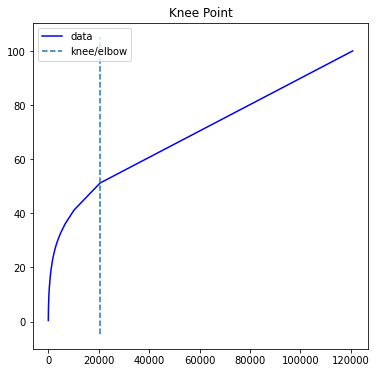

In [24]:
prefix_suffix_kneedle = KneeLocator(x=df_prefix_suffix_freq.cumul_ratio.index, y=df_prefix_suffix_freq.cumul_ratio, S=1.0, curve="concave", direction="increasing")
prefix_suffix_kneedle.plot_knee()

In [25]:
knee_point_prefix_suffix = round(prefix_suffix_kneedle.knee_y)
knee_point_prefix_suffix

51

In [26]:
df_prefix_suffix_knee = df_prefix_suffix_freq[df_prefix_suffix_freq.cumul_ratio <= knee_point_prefix_suffix]
df_prefix_suffix_knee

,prefix_suffix,frequency,ratio,cumul_ratio
0,+,800,0.389655,0.389655
1,+n,257,0.125177,0.514831
2,+da,242,0.117871,0.632702
3,+i,241,0.117384,0.750085
4,+lar,238,0.115922,0.866008
...,...,...,...,...
20272,+şşiz,2,0.000974,50.995666
20273,+cları,2,0.000974,50.996640
20274,+yrımız,2,0.000974,50.997614
20275,+ppley,2,0.000974,50.998588


In [27]:
prefix_suffix_list = df_prefix_suffix_knee["prefix_suffix"].to_list()

In [28]:
disable_prefix_suffix_list = ["+anityi","+bidir","+workun","+düktörlere","+rysin","+ein","+ei","+x","+ren","+hul"]

In [29]:
set_prefix_suffix = set(prefix_suffix_list)
set_disable_prefix_suffix = set(disable_prefix_suffix_list)

In [30]:
prefix_suffix_custom_list = list(set_prefix_suffix.difference(set_disable_prefix_suffix))

In [31]:
df_prefix_suffix_custom = pd.DataFrame()
for i in prefix_suffix_custom_list:
    df_var = df_prefix_suffix[df_prefix_suffix["prefix_suffix"] == f"{i}"]
    df_prefix_suffix_custom = pd.concat([df_prefix_suffix_custom, df_var], axis=0)
df_prefix_suffix_custom.sort_values(by="word", inplace=True)
df_prefix_suffix_custom.reset_index(drop=True, inplace=True)
df_prefix_suffix_custom

,search_word,word,frequency,prefix_suffix,prefix_suffix_len
0,a,a,129150,+,0
1,a,aa,15799,+a,1
2,a,aaa,6402,+aa,2
3,a,aaaa,832,+aaa,3
4,a,aaaaa,245,+aaaa,4
...,...,...,...,...,...
104653,şöyle,şöyleyelim,7,+yelim,5
104654,şöyle,şöyleyim,85,+yim,3
104655,şöyle,şöyleyimdir,6,+yimdir,6
104656,şöyle,şöyleyin,7,+yin,3


In [32]:
df_frequency_mean = df_prefix_suffix_custom.groupby(["search_word"])[["frequency"]].mean()
df_frequency_mean.reset_index(inplace=True)
df_frequency_mean.rename(columns={"frequency":"frequency_mean"}, inplace=True)
df_frequency_mean

,search_word,frequency_mean
0,a,3419.031838
1,acaba,36017.250000
2,acele,4826.000000
3,acil,2071.884615
4,acı,775.299550
...,...,...
795,şeyin,7489.400000
796,şeyleri,5381.029412
797,şimdiye,71220.000000
798,şuna,47243.666667


In [33]:
df_prefix_suffix_freq_mean = pd.merge(df_prefix_suffix_custom, df_frequency_mean, how="inner", on="search_word")
df_prefix_suffix_freq_mean

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,a,a,129150,+,0,3419.031838
1,a,aa,15799,+a,1,3419.031838
2,a,aaa,6402,+aa,2,3419.031838
3,a,aaaa,832,+aaa,3,3419.031838
4,a,aaaaa,245,+aaaa,4,3419.031838
...,...,...,...,...,...,...
104653,şöyle,şöyleyelim,7,+yelim,5,4839.080000
104654,şöyle,şöyleyim,85,+yim,3,4839.080000
104655,şöyle,şöyleyimdir,6,+yimdir,6,4839.080000
104656,şöyle,şöyleyin,7,+yin,3,4839.080000


In [34]:
df_prefix_suffix_freq_mean_select = df_prefix_suffix_freq_mean[(df_prefix_suffix_freq_mean.frequency >= df_prefix_suffix_freq_mean.frequency_mean)]
df_prefix_suffix_freq_mean_select.reset_index(drop=True, inplace=True)
df_prefix_suffix_freq_mean_select

,search_word,word,frequency,prefix_suffix,prefix_suffix_len,frequency_mean
0,a,a,129150,+,0,3419.031838
1,a,aa,15799,+a,1,3419.031838
2,a,aaa,6402,+aa,2,3419.031838
3,a,aaah,3499,+aah,3,3419.031838
4,a,aah,13938,+ah,2,3419.031838
...,...,...,...,...,...,...
9124,şeyleri,şeyleri,137646,+,0,5381.029412
9125,şeyleri,şeylerin,36582,+n,1,5381.029412
9126,şimdiye,şimdiye,71220,+,0,71220.000000
9127,şuna,şuna,141710,+,0,47243.666667


In [35]:
df_prefix_suffix_freq_mean_select.search_word.nunique()

800

In [36]:
df_prefix_suffix_freq_mean_select.word.nunique()

7610

In [37]:
if word_analysis:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)
else:
    df_prefix_suffix_freq_mean_select.to_excel(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx", index=False)

##### Copy Move And Delete

In [38]:
output_file1 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*Result.xlsx")
output_file1

['Turkish_English_1000_Word_Prefix_Suffix_Custom_Result.xlsx']

In [39]:
for k in output_file1:
    source = k # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [40]:
for i in output_file1:
    try:
        os.remove(i)
    except:
        pass

In [41]:
output_file2 = glob.glob(f"{lang_folder.capitalize()}_{lang_pair.capitalize()}_*_Prefix_Suffix_*.xlsx")
output_file2

['Turkish_English_1000_Word_Prefix_Suffix_All.xlsx',
 'Turkish_English_1000_Word_Prefix_Suffix_Select.xlsx']

In [42]:
for l in output_file2:
    source = l # source directory
    destination = f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Data/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}"
    shutil.copy2(source, destination)

In [43]:
for j in output_file2:
    try:
        os.remove(j)
    except:
        pass

### Concat Native And Etymology Prefix Suffix Result

In [3]:
import os
import pandas as pd
import numpy as np
import glob

In [4]:
# language pair
lang_folder = "Turkish"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian ==> target language for learner
lang_pair = "English"  # Arabic, English, French, German, Turkish, Spanish, Portuguese, Dutch, Italian, Intersect ==> native language

# file extention
file_ext = 200  # native word number

In [5]:
def lower_strip(x):
    try:
        var_low = x.lower()
        var_out = var_low.strip()
    except:
        var_out = x
    return var_out

In [6]:
native_file = glob.glob(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Word_Prefix_Suffix_Custom_Result_Manuel.xlsx")
native_file

['/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/Turkish English/Turkish_English_200_Word_Prefix_Suffix_Custom_Result_Manuel.xlsx']

In [7]:
df_native = pd.read_excel(native_file[0])
df_native = df_native[["search_word","word"]]
df_native

,search_word,word
0,adam,adam
1,adam,adama
2,adam,adamdan
3,adam,adamdı
4,adam,adamdır
...,...,...
1618,şey,şeyler
1619,şey,şeylerden
1620,şey,şeylere
1621,şey,şeyleri


In [8]:
etymology_file = glob.glob(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} {lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_Shared_Word_Prefix_Suffix_Custom_Result.xlsx")
etymology_file

['/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/Turkish English/Turkish_English_Shared_Word_Prefix_Suffix_Custom_Result.xlsx']

In [9]:
df_etmology = pd.read_excel(etymology_file[0])
df_etmology = df_etmology[["search_word","word"]]
df_etmology

,search_word,word
0,abaküs,abaküs
1,abandone,abandoned
2,abanoz,abanoz
3,abdomen,abdomende
4,abluka,abluka
...,...,...
6188,şut,şutu
6189,şut,şutunu
6190,şırınga,şırınga
6191,şırınga,şırıngayla


In [10]:
df_native_etymology_concat = pd.concat([df_native,df_etmology], axis=0)
df_native_etymology_concat

,search_word,word
0,adam,adam
1,adam,adama
2,adam,adamdan
3,adam,adamdı
4,adam,adamdır
...,...,...
6188,şut,şutu
6189,şut,şutunu
6190,şırınga,şırınga
6191,şırınga,şırıngayla


In [11]:
df_native_etymology_concat["search_word"] = df_native_etymology_concat["search_word"].apply(lambda x : lower_strip(x))
df_native_etymology_concat["word"] = df_native_etymology_concat["word"].apply(lambda x : lower_strip(x))
df_native_etymology_concat.drop_duplicates(inplace=True)
df_native_etymology_concat.reset_index(drop=True, inplace=True)
df_native_etymology_concat

,search_word,word
0,adam,adam
1,adam,adama
2,adam,adamdan
3,adam,adamdı
4,adam,adamdır
...,...,...
7811,şut,şutu
7812,şut,şutunu
7813,şırınga,şırınga
7814,şırınga,şırıngayla


In [12]:
df_native_etymology_concat.to_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/{lang_folder.capitalize()}/{lang_folder.capitalize()} \
{lang_pair.capitalize()}/{lang_folder.capitalize()}_{lang_pair.capitalize()}_{file_ext}_Native_And_Shared_Word_Prefix_Suffix_Custom_Concat.xlsx", index=False)

### Temp

In [ ]:
# English, French, German, Spanish, Portuguese, Dutch, Italian

In [29]:
#df_pair1 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish English/Turkish_English_Shared_Vocabulary.xlsx")
#df_pair1

In [31]:
#df_pair2 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish French/Turkish_French_Shared_Vocabulary.xlsx")
#df_pair2

In [32]:
#df_pair3 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish German/Turkish_German_Shared_Vocabulary.xlsx")
#df_pair3

In [33]:
#df_pair4 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish Spanish/Turkish_Spanish_Shared_Vocabulary.xlsx")
#df_pair4

In [34]:
#df_pair5 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish Portuguese/Turkish_Portuguese_Shared_Vocabulary.xlsx")
#df_pair5

In [35]:
#df_pair6 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish Dutch/Turkish_Dutch_Shared_Vocabulary.xlsx")
#df_pair6

In [36]:
#df_pair7 = pd.read_excel(f"/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/\
#Turkish Italian/Turkish_Italian_Shared_Vocabulary.xlsx")
#df_pair7

In [ ]:
#set1 = set(df_pair1.dict_entry_main)
#set2 = set(df_pair2.dict_entry_main)
#set3 = set(df_pair3.dict_entry_main)
#set4 = set(df_pair4.dict_entry_main)
#set5 = set(df_pair5.dict_entry_main)
#set6 = set(df_pair6.dict_entry_main)
#set7 = set(df_pair7.dict_entry_main)

In [ ]:
#df_ety_intersect = pd.DataFrame((((((set7.intersection(set6)).intersection(set5)).intersection(set4)).intersection(set3)).intersection(set2)).intersection(set1), columns=["dict_entry_main"])
#df_ety_intersect

In [ ]:
#df_ety_intersect.to_excel("Turkish_Intersect_Shared_Vocabulary.xlsx", index=False)

In [19]:
#df_intersect = pd.read_excel("/media/kurubal/SSD/Data Scientist/Work/Modern Ways/Project/Web Scrapping/Result/Turkish/Turkish Intersect/Turkish_Intersect_Shared_Vocabulary.xlsx")
#df_intersect  # English, French, German, Spanish, Portuguese, Dutch, Italian

In [20]:
#df_pair1_merge = pd.merge(df_intersect,df_pair1, how="left", on="dict_entry_main")
#df_pair1_merge.drop_duplicates(inplace=True)
#df_pair1_merge

In [21]:
#df_pair2_merge = pd.merge(df_pair1_merge,df_pair2, how="left", on="dict_entry_main")
#df_pair2_merge.drop_duplicates(inplace=True)
#df_pair2_merge

In [22]:
#df_pair3_merge = pd.merge(df_pair2_merge,df_pair3, how="left", on="dict_entry_main")
#df_pair3_merge.drop_duplicates(inplace=True)
#df_pair3_merge

In [23]:
#df_pair4_merge = pd.merge(df_pair3_merge,df_pair4, how="left", on="dict_entry_main")
#df_pair4_merge.drop_duplicates(inplace=True)
#df_pair4_merge

In [24]:
#df_pair5_merge = pd.merge(df_pair4_merge,df_pair5, how="left", on="dict_entry_main")
#df_pair5_merge.drop_duplicates(inplace=True)
#df_pair5_merge

In [25]:
#df_pair6_merge = pd.merge(df_pair5_merge,df_pair6, how="left", on="dict_entry_main")
#df_pair6_merge.drop_duplicates(inplace=True)
#df_pair6_merge

In [26]:
#df_pair7_merge = pd.merge(df_pair6_merge,df_pair7, how="left", on="dict_entry_main")
#df_pair7_merge.drop_duplicates(inplace=True)
#df_pair7_merge

In [27]:
#df_pair7_merge.rename(columns={"dict_entry_main":"turkish_word_intersect"}, inplace=True)
#df_pair7_merge

In [28]:
#df_pair7_merge.to_excel("Turkish_Intersect_Shared_Vocabulary_With_Other_Languages.xlsx", index=False)